In [2]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('train_rmvnan_0207_ver1.csv',low_memory=False, parse_dates=['visitStartTime'])
df.head()

,fullVisitorId,date,visitId,visitNumber,visitStartTime,channelGrouping,device_browser,device_operatingSystem,device_isMobile,device_deviceCategory,...,trafficSource_source,trafficSource_medium,trafficSource_keyword,trafficSource_isTrueDirect,trafficSource_referralPath,trafficSource_adwordsClickInfo_page,trafficSource_adwordsClickInfo_slot,trafficSource_adwordsClickInfo_adNetworkType,trafficSource_adwordsClickInfo_isVideoAd,trafficSource_adContent
0,1131660440785968503,2016-09-02,1472830385,1,2016-09-02 15:33:05,Organic Search,Chrome,Windows,False,desktop,...,google,organic,(not provided),NaN,NaN,0.0,NaN,NaN,NaN,NaN
1,377306020877927890,2016-09-03,1472880147,1,2016-09-03 05:22:27,Organic Search,Firefox,Macintosh,False,desktop,...,google,organic,(not provided),NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,3895546263509774583,2016-09-03,1472865386,1,2016-09-03 01:16:26,Organic Search,Chrome,Windows,False,desktop,...,google,organic,(not provided),NaN,NaN,0.0,NaN,NaN,NaN,NaN
3,4763447161404445595,2016-09-03,1472881213,1,2016-09-03 05:40:13,Organic Search,UC Browser,Linux,False,desktop,...,google,organic,google + online,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,27294437909732085,2016-09-02,1472822600,2,2016-09-02 13:23:20,Organic Search,Chrome,Android,True,mobile,...,google,organic,(not provided),True,NaN,0.0,NaN,NaN,NaN,NaN


In [3]:
# df['visitStartTime'] = pd.to_datetime(df['visitStartTime'], errors='coerce')
# iso캘린더로 다시 추출해서 그래프 띄우기
# date_iso = df['visitStartTime'].dt.isocalendar()
# a = date_iso.loc[:, 'year']
# b = date_iso.loc[:, 'week']
# a = a.astype(str)
# b = b.astype(str)
# df['VisitCycle'] = a+'.'+b
# df['VisitCycle'].astype(str)
df['VisitCycle'] = df['visitStartTime'].dt.strftime('%G.%V')

In [5]:
first_visit = df.groupby('fullVisitorId').visitStartTime.min()
first_visit = first_visit.dt.strftime('%G.%V')
first_visit.sample(4)

fullVisitorId
3643265036946575338    2017.08
8231074509400633088    2016.44
0912909436670301478    2017.17
8219680541679430163    2017.16
Name: visitStartTime, dtype: object

In [6]:
df = df.set_index('fullVisitorId')


In [7]:
df['FirstVisit'] = first_visit


In [8]:
df.reset_index(inplace = True)


In [9]:
co1 = df.groupby(['FirstVisit', 'VisitCycle']).fullVisitorId.nunique()
co1 = co1.reset_index()
co1.rename({'fullVisitorId': 'TotalVisitor'}, axis = 1, inplace = True)

In [12]:
from ipypb import ipb


temp_week_diff = []
for i in ipb(range(co1.shape[0])):
    # '2016.31'과 같은 형식을 '2016-31'로 변경
    formatted_first_visit = co1.FirstVisit[i].replace('.', '-') + '-1'  # 1일로 설정
    formatted_visit_cycle = co1.VisitCycle[i].replace('.', '-') + '-1'  # 1일로 설정
    
    # 주차 정보 추출 및 정수로 변환
    f_first_visit = pd.to_datetime(formatted_first_visit, format='%Y-%W-%w')
    f_visit_cycle = pd.to_datetime(formatted_visit_cycle, format='%Y-%W-%w')
    week_diff = (f_visit_cycle - f_first_visit).days // 7
    
    temp_week_diff.append(week_diff)


 [████████████████████████████████████████████████████████████] 1424/1424 [00:00<00:00, 0.00s/it]

In [13]:
# 새로운 리스트를 사용하여 'CohortPeriodWeek' 열에 값을 할당
co1['CohortPeriodWeek'] = temp_week_diff

In [14]:
# 중복된 조합을 제거하여 고유한 값으로 새로운 데이터프레임 생성
unique_combinations = co1[['FirstVisit', 'CohortPeriodWeek']].drop_duplicates()

In [15]:
unique_combinations

,FirstVisit,CohortPeriodWeek
0,2016.31,0
1,2016.31,1
2,2016.31,2
3,2016.31,3
4,2016.31,4
...,...,...
1419,2017.29,1
1420,2017.29,2
1421,2017.30,0
1422,2017.30,1


In [16]:
# 중복을 제거한 데이터프레임과 원본 데이터프레임을 합침
co_unique = pd.merge(unique_combinations, co1, on=['FirstVisit', 'CohortPeriodWeek'], how='inner')

# 'VisitCycle' 값이 '2016.52' 및 '2017.00' 중 어느 것을 선택할지 결정 필요
# 여기서는 첫 번째로 나타난 값을 선택
co_unique = co_unique.groupby(['FirstVisit', 'CohortPeriodWeek']).first().reset_index()

co_retention = co_unique.set_index(['FirstVisit', 'CohortPeriodWeek'])
co_retention = co_retention.TotalVisitor.unstack(1)
retention = co_retention.div(co_retention[0],axis = 0)

In [17]:
co_retention

CohortPeriodWeek,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
FirstVisit,,,,,,,,,,,,,,,,,,,,,
2016.31,13476.0,675.0,443.0,316.0,279.0,217.0,198.0,171.0,140.0,162.0,...,11.0,15.0,11.0,11.0,13.0,10.0,9.0,15.0,16.0,5.0
2016.32,14098.0,583.0,351.0,258.0,183.0,166.0,120.0,93.0,104.0,81.0,...,7.0,7.0,10.0,5.0,4.0,9.0,5.0,6.0,1.0,NaN
2016.33,14004.0,480.0,296.0,235.0,202.0,126.0,85.0,100.0,78.0,70.0,...,6.0,11.0,3.0,5.0,8.0,4.0,4.0,2.0,NaN,NaN
2016.34,13035.0,381.0,221.0,181.0,153.0,93.0,114.0,82.0,54.0,46.0,...,7.0,3.0,2.0,6.0,8.0,2.0,2.0,NaN,NaN,NaN
2016.35,13922.0,379.0,230.0,197.0,150.0,127.0,89.0,69.0,54.0,49.0,...,1.0,8.0,4.0,5.0,3.0,3.0,NaN,NaN,NaN,NaN
2016.36,12778.0,369.0,203.0,149.0,170.0,82.0,68.0,52.0,34.0,35.0,...,3.0,1.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2016.37,13140.0,413.0,231.0,246.0,175.0,111.0,74.0,64.0,58.0,58.0,...,5.0,7.0,9.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2016.38,13246.0,418.0,277.0,182.0,139.0,91.0,75.0,67.0,70.0,52.0,...,1.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016.39,12826.0,408.0,220.0,164.0,129.0,91.0,82.0,61.0,55.0,56.0,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
pd.set_option('display.max_columns', None)
retention_per = retention*100
retention_per

CohortPeriodWeek,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52
FirstVisit,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016.31,100.0,5.008905,3.287326,2.344909,2.070347,1.610270,1.469279,1.268923,1.038884,1.202137,0.868210,0.734639,0.563966,0.630751,0.519442,0.549124,0.378451,0.534283,0.422974,0.452657,0.341348,0.185515,0.192936,0.289403,0.274562,0.274562,0.148412,0.192936,0.170674,0.192936,0.237459,0.170674,0.215197,0.148412,0.140991,0.103888,0.111309,0.089047,0.089047,0.155833,0.081627,0.126150,0.118730,0.081627,0.111309,0.081627,0.081627,0.096468,0.074206,0.066785,0.111309,0.118730,0.037103
2016.32,100.0,4.135338,2.489715,1.830047,1.298056,1.177472,0.851185,0.659668,0.737693,0.574550,0.418499,0.347567,0.383033,0.333381,0.290821,0.340474,0.340474,0.297915,0.205703,0.212796,0.134771,0.163144,0.120584,0.148957,0.170237,0.099305,0.106398,0.156051,0.099305,0.127678,0.099305,0.063839,0.063839,0.106398,0.099305,0.056746,0.070932,0.099305,0.070932,0.063839,0.092212,0.056746,0.042559,0.049652,0.049652,0.070932,0.035466,0.028373,0.063839,0.035466,0.042559,0.007093,NaN
2016.33,100.0,3.427592,2.113682,1.678092,1.442445,0.899743,0.606969,0.714082,0.556984,0.499857,0.357041,0.278492,0.214225,0.242788,0.257069,0.278492,0.221365,0.235647,0.242788,0.107112,0.221365,0.157098,0.092831,0.121394,0.121394,0.064267,0.164239,0.085690,0.071408,0.107112,0.099971,0.064267,0.071408,0.078549,0.035704,0.121394,0.078549,0.071408,0.049986,0.078549,0.071408,0.049986,0.042845,0.042845,0.078549,0.021422,0.035704,0.057127,0.028563,0.028563,0.014282,NaN,NaN
2016.34,100.0,2.922900,1.695435,1.388569,1.173763,0.713464,0.874568,0.629076,0.414269,0.352896,0.276180,0.299194,0.230150,0.291523,0.268508,0.314538,0.168776,0.176448,0.107403,0.115075,0.092060,0.107403,0.138090,0.092060,0.076717,0.130418,0.061373,0.061373,0.053702,0.046030,0.061373,0.053702,0.046030,0.053702,0.061373,0.099731,0.046030,0.076717,0.061373,0.053702,0.061373,0.053702,0.046030,0.053702,0.023015,0.015343,0.046030,0.061373,0.015343,0.015343,NaN,NaN,NaN
2016.35,100.0,2.722310,1.652061,1.415027,1.077431,0.912225,0.639276,0.495618,0.387875,0.351961,0.244218,0.287315,0.222669,0.308864,0.244218,0.222669,0.100560,0.064646,0.158023,0.114926,0.093377,0.071829,0.064646,0.064646,0.086195,0.107743,0.071829,0.050280,0.043097,0.057463,0.064646,0.057463,0.035914,0.035914,0.064646,0.050280,0.021549,0.071829,0.035914,0.035914,0.028732,0.021549,0.021549,0.007183,0.057463,0.028732,0.035914,0.021549,0.021549,NaN,NaN,NaN,NaN
2016.36,100.0,2.887776,1.588668,1.166067,1.330412,0.641728,0.532165,0.406949,0.266082,0.273908,0.219127,0.258256,0.273908,0.242604,0.211301,0.125215,0.070434,0.078260,0.101737,0.109563,0.086085,0.070434,0.046956,0.070434,0.062608,0.023478,0.031304,0.046956,0.046956,0.031304,0.062608,0.007826,0.062608,0.046956,0.031304,0.031304,0.046956,0.039130,0.015652,0.039130,0.062608,0.023478,NaN,0.023478,0.007826,0.023478,0.007826,NaN,NaN,NaN,NaN,NaN,NaN
2016.37,100.0,3.143075,1.757991,1.872146,1.331811,0.844749,0.563166,0.487062,0.441400,0.441400,0.357686,0.388128,0.342466,0.243531,0.182648,0.098935,0.136986,0.129376,0.129376,0.129376,0.076104,0.060883,0.129376,0.068493,0.098935,0.114155,0.053272,0.053272,0.136986,0.045662,0.076104,0.076104,0.098935,0.060883,0.045662,0.076104,0.068493,0.045662,0.045662,0.045662,0.030441,0.030441,0.015221,0.038052,0.053272,0.068493,0.007610,NaN,NaN,NaN,NaN,NaN,NaN
2016.38,100.0,3.155670,2.091197,1.374000,1.049373,0.687000,0.566209,0.505813,0.528461,0.392571,0.339725,0.362374,0.249132,0.203835,0.120791,0.113242,0.173637,0.143440,0.120791,0.098143,0.098143,0.143440,0.075494,0.098143,0.075494,0.060396,0.045297,0.105692,0.083044,0.105692,0.052846,0.105692,0.015099,0.037747,0.083044,0.052846,0.007549,0.052846,0.022648,0.022648,0.015099,0.030198,0.022648,0.007549,0.015099,0.007549,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016.39,100.0,3.181039,1.715266,1.278653,1.005770,0.709496,0.639

In [86]:
#Nan 값 0으로 치환
retention_per.loc['2016.47', 35] = 0
retention_per.loc['2016.36', 42] = 0
retention_per.loc['2016.51', 32] = 0
retention_per.loc['2016.43', 40] = 0
retention_per.loc['2016.40', 43] = 0
retention_per.loc['2016.39', 44] = 0 
retention_per.loc['2016.36', 47] = 0 

<Axes: xlabel='CohortPeriodWeek', ylabel='FirstVisit'>

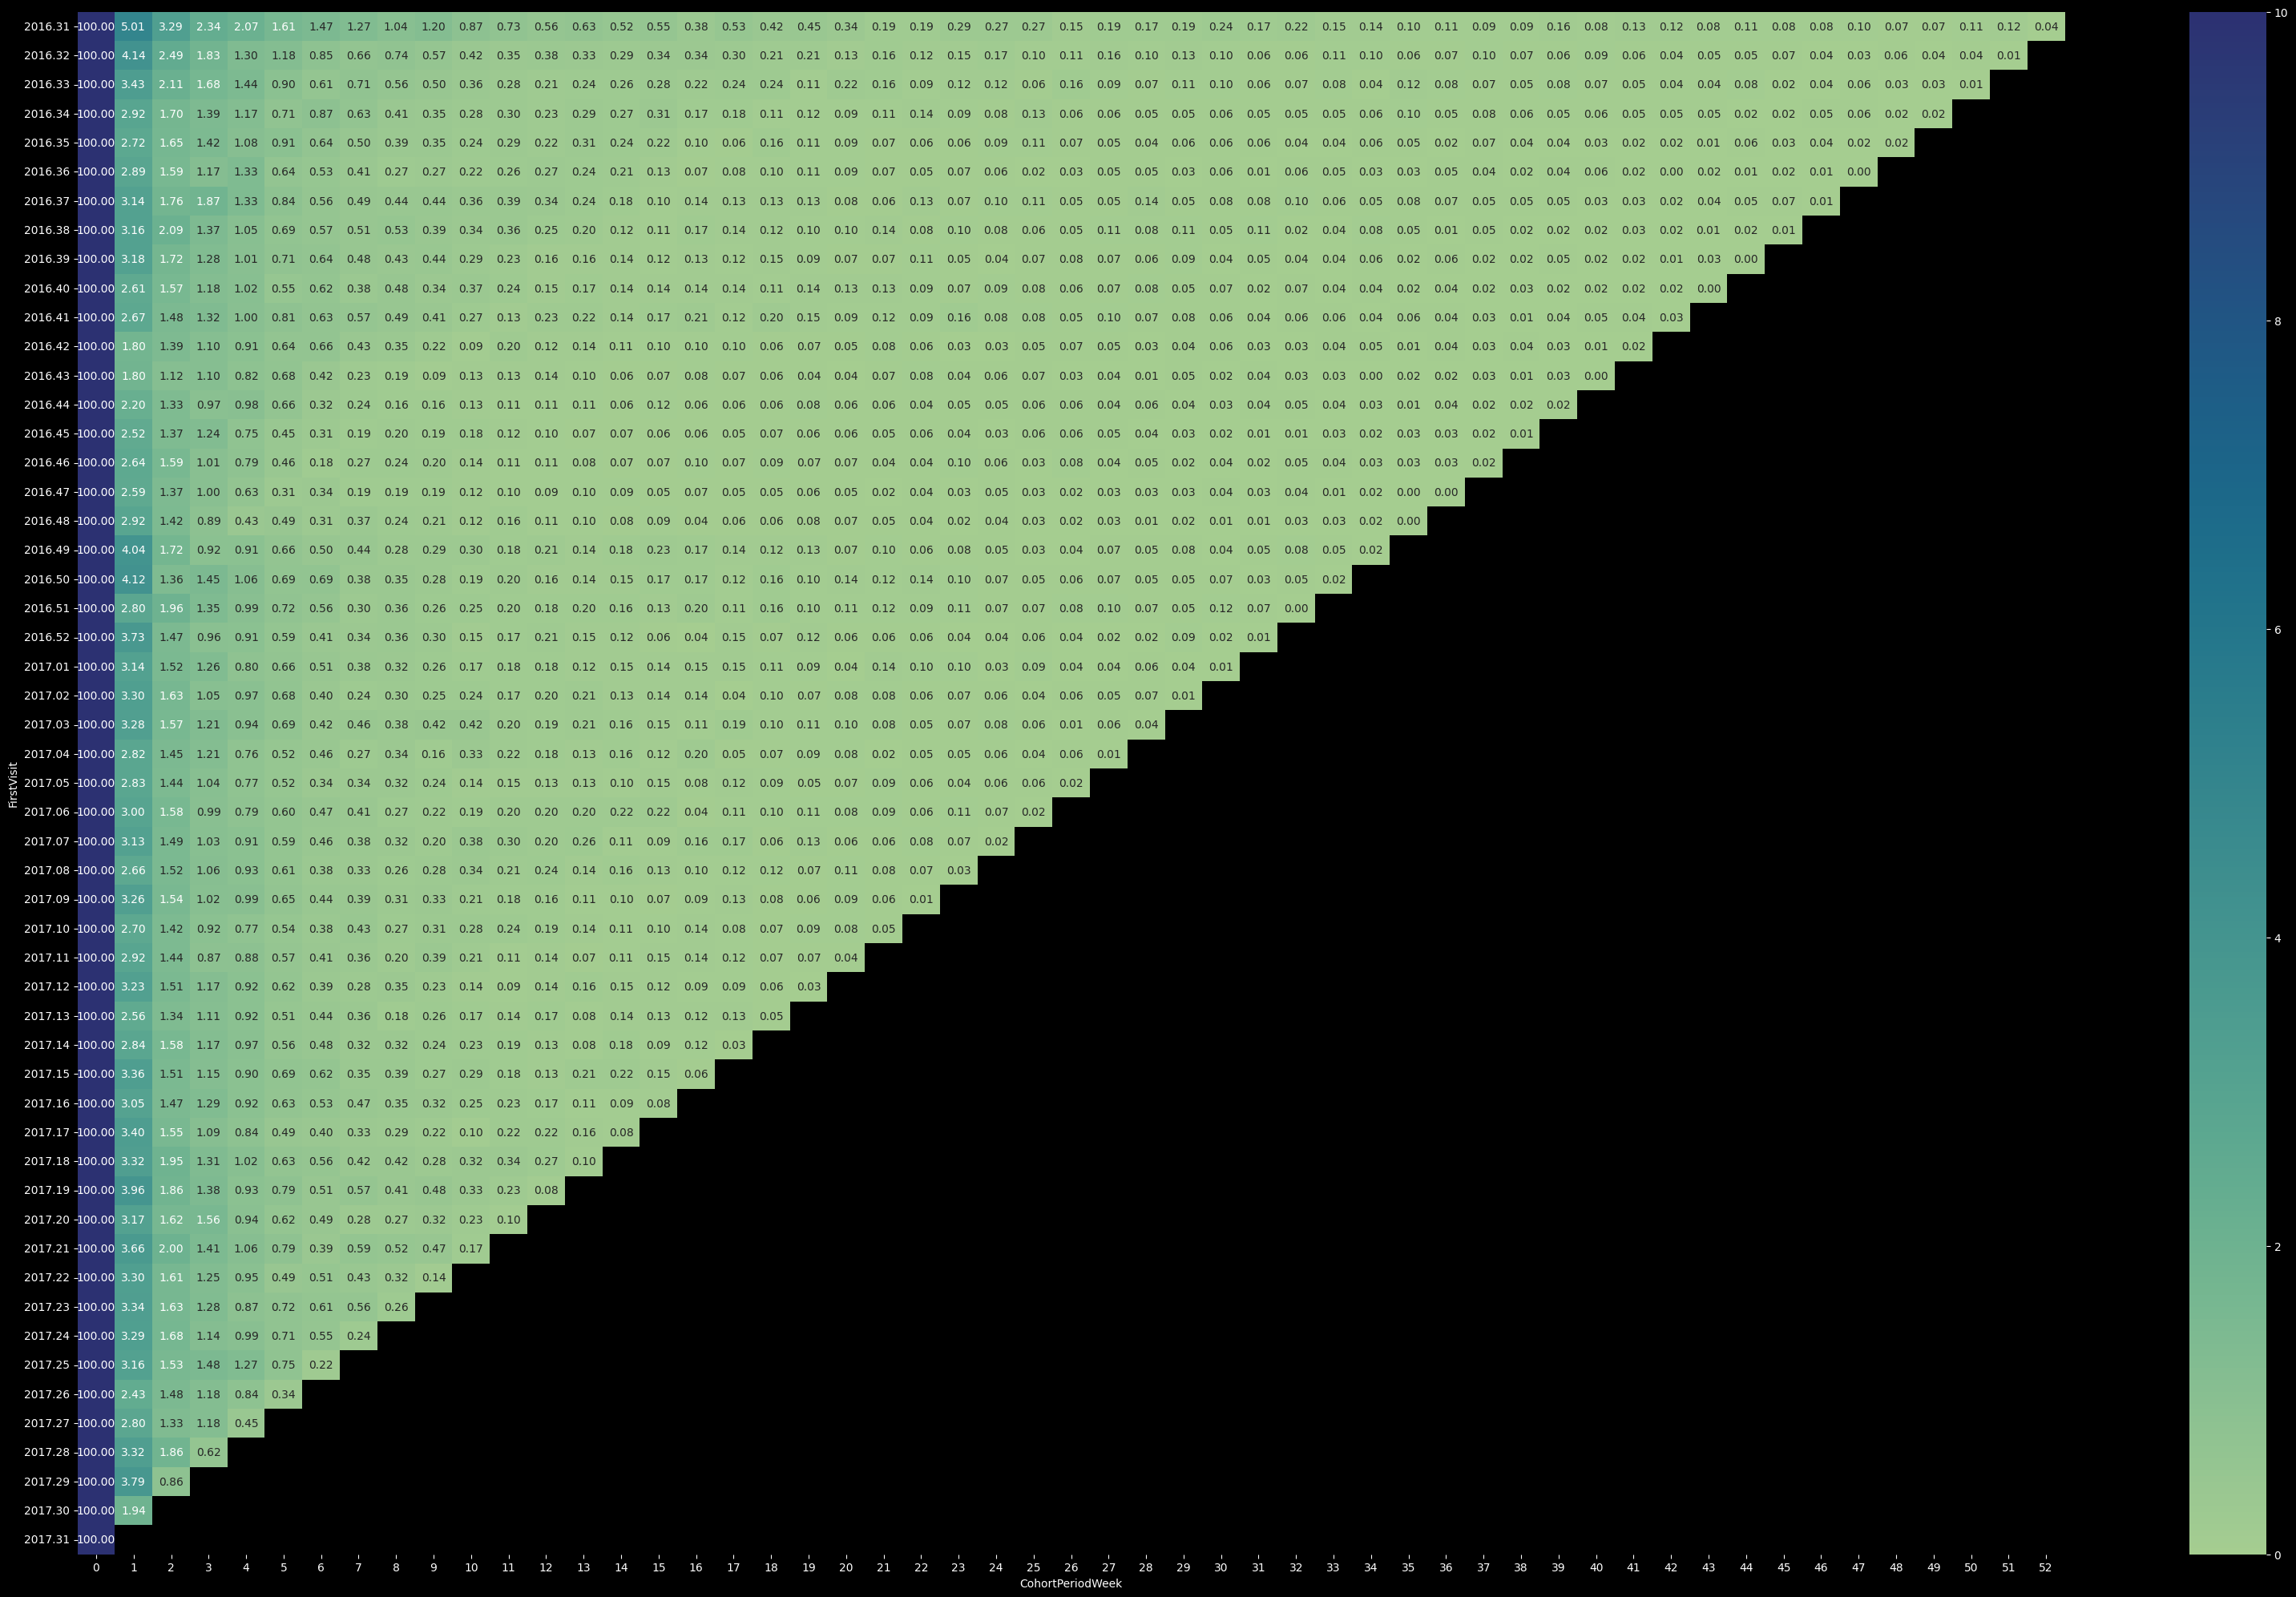

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(40,25))
sns.heatmap(retention_per, cmap='crest',annot=True, fmt='.2f', vmin=0, vmax=10)

<Axes: xlabel='CohortPeriodWeek', ylabel='FirstVisit'>

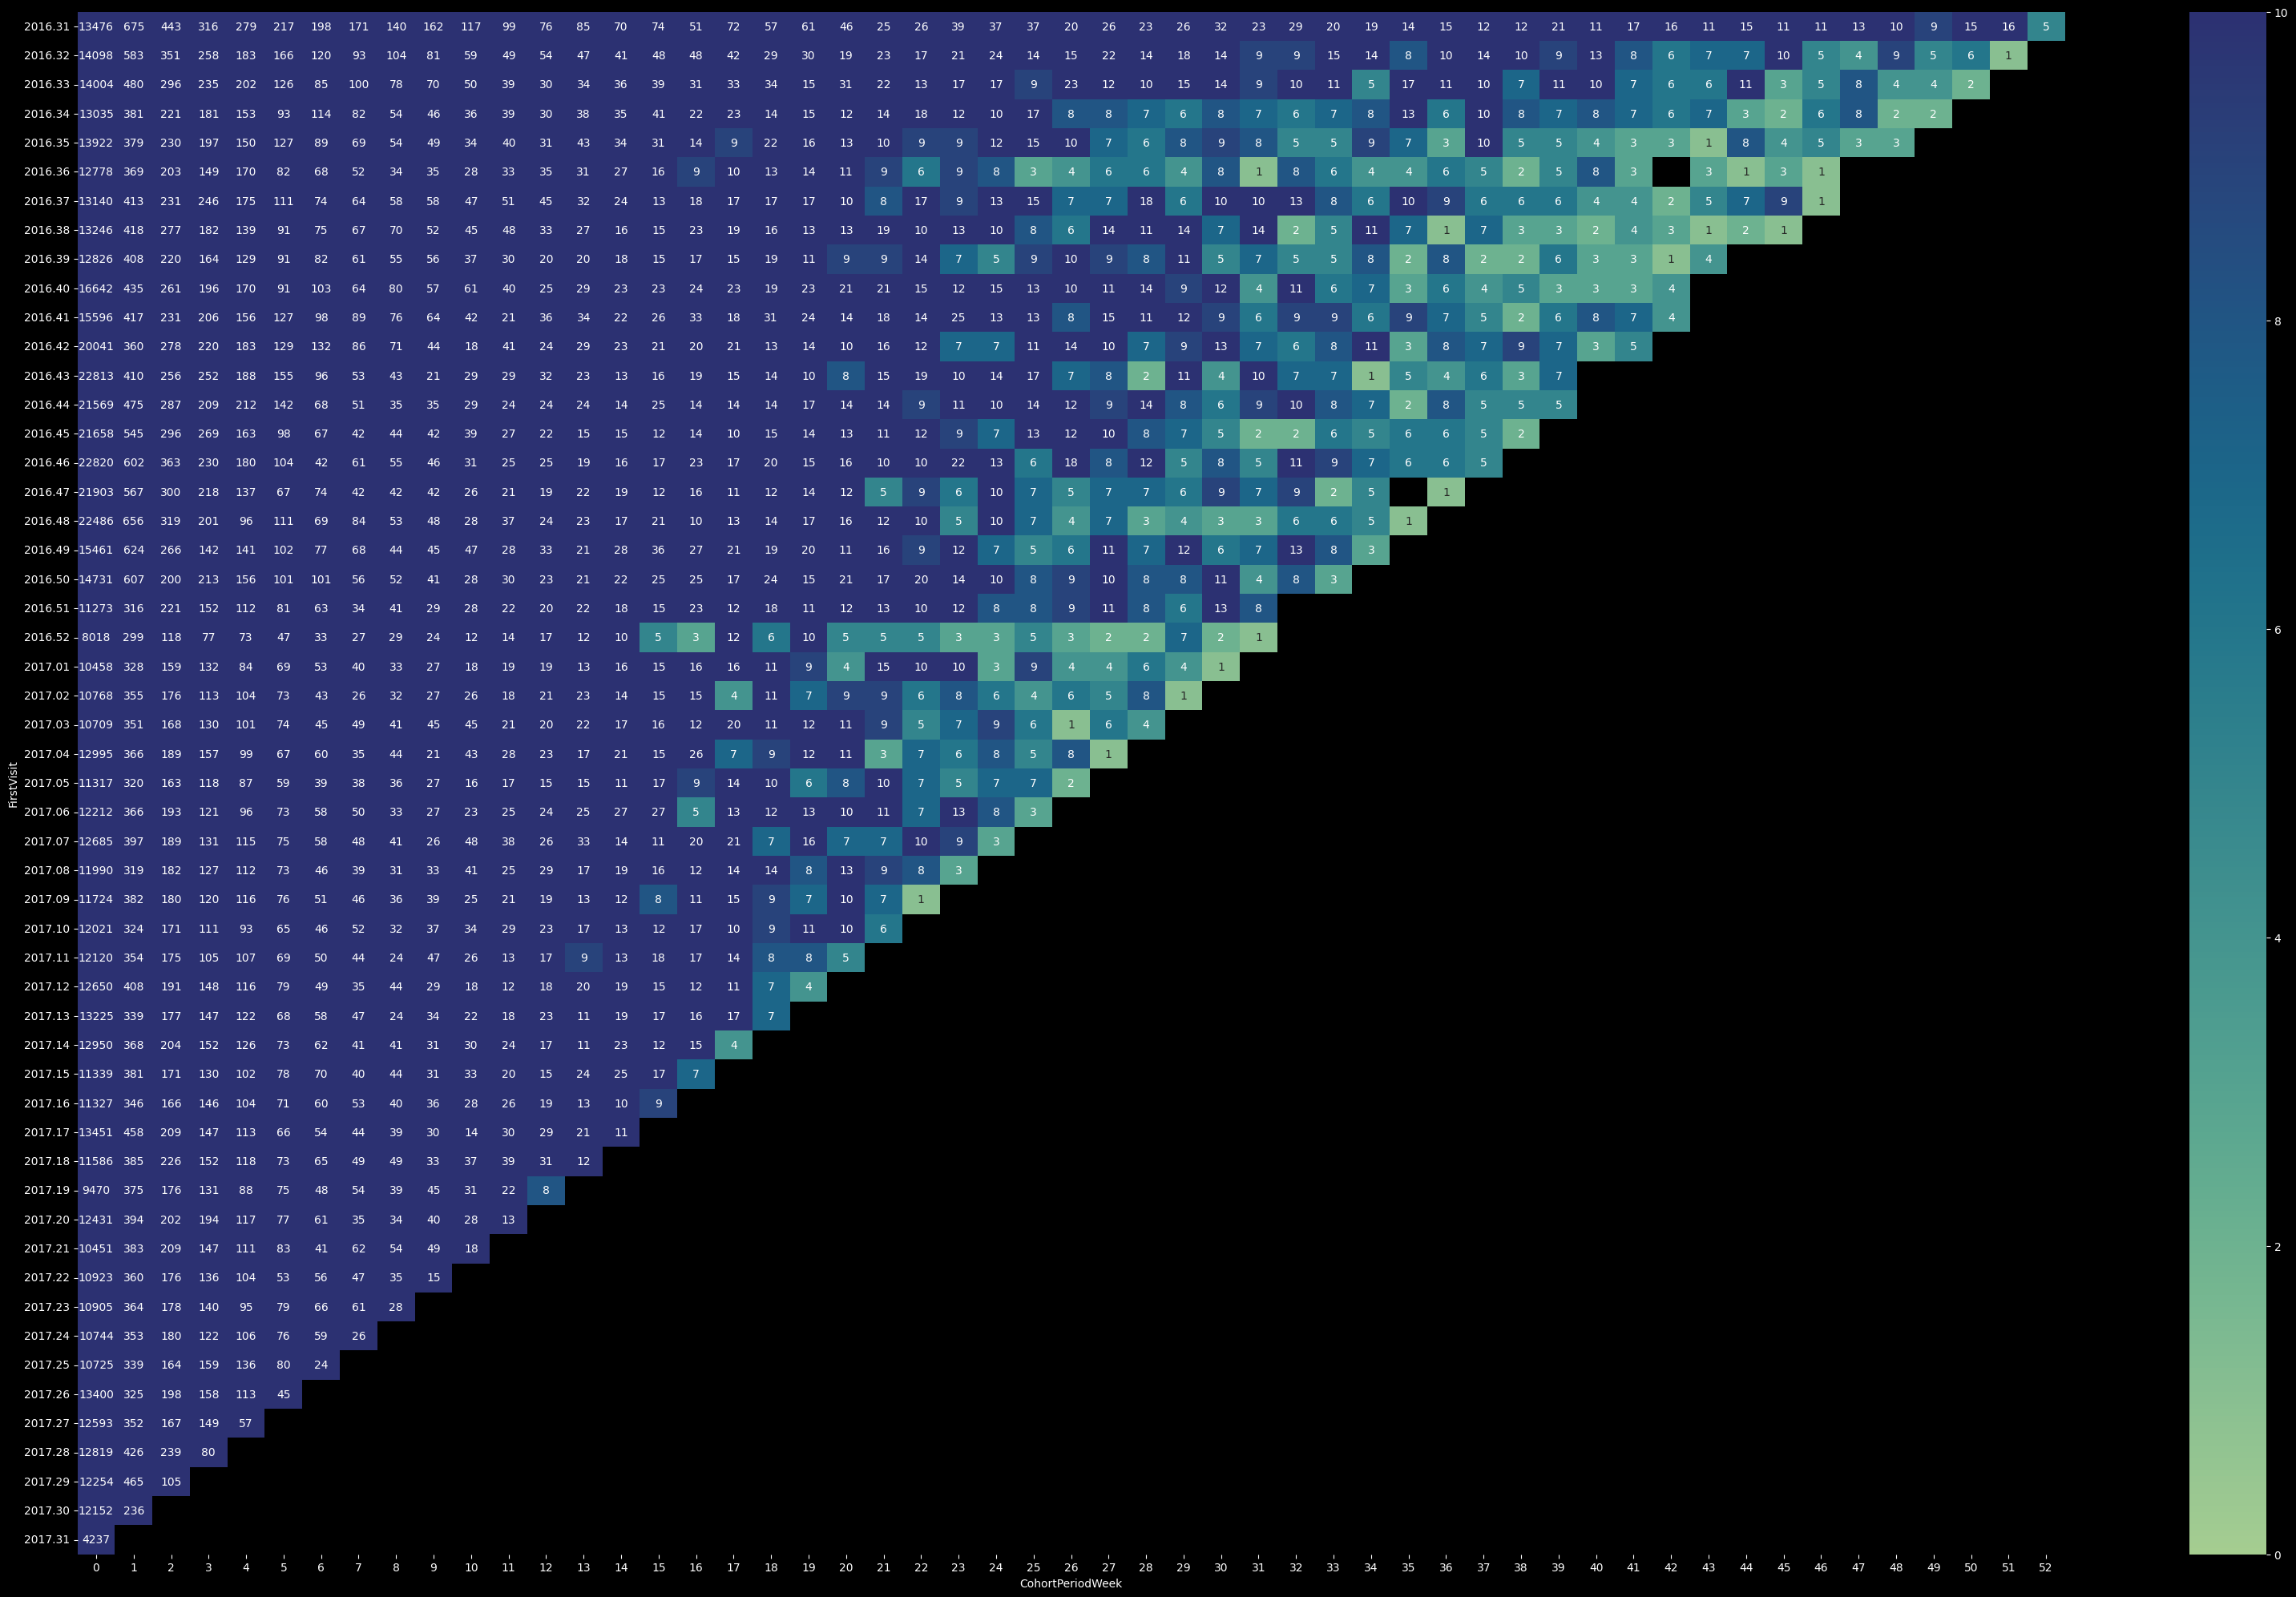

In [21]:
co_retention

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(40,25))
sns.heatmap(co_retention, cmap='crest',annot=True, fmt='.0f', vmin=0, vmax=10)